# MOVIE STUDIO ANALYSIS

## Business Understanding

##### Our company has decided to create a new movie studio, but they don’t know anything about creating movies. We have been charged with exploring what types of films are currently doing the best at the box office. We must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.Our focus will be to make suggestions for the type of movies that will be the most profitable for our new movie division.

## Data Understanding


We will be using the following datasets;

1.`rt.reviews.tsv` from [Rotten Tomatoes](https://www.rottentomatoes.com)

2.`im.db` from [IMDB](https://www.imdb.com/)

3.`bom.movie_gross.csv` from [BOXOFFICE MOJO](https://www.boxofficemojo.com/)

##### Importing libraries

In [41]:

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

##### Loading Datasets

In [42]:

file_path = 'data/rt.reviews.tsv'

try:
  reviews_df = pd.read_csv(file_path, sep='\t',on_bad_lines='skip',encoding='ISO-8859-1')
except pd.errors.ParserError as e:
    print(f'Error parsing file:{e}')
reviews_df


,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [43]:
conn = sqlite3.connect('data/im.db')
q = """SELECT *
FROM movie_basics
JOIN movie_ratings
USING(movie_id)"""
imdb_df = pd.read_sql(q,conn)
imdb_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [44]:
path = 'data/tn.movie_budgets.csv'
movie_budgets_df = pd.read_csv(path)

In [45]:
path = 'data/rt.movie_info.tsv'
try:
  movie_info_df = pd.read_csv(path, sep='\t',on_bad_lines='skip',encoding='ISO-8859-1')
except pd.errors.ParserError as e:
    print(f'Error parsing file:{e}')


## Data Cleaning

In [46]:
# reviews_df
# using .info to understand the dataset
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [47]:
# movie_info_df
movie_info_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [48]:
#merging reviews_df and movie_info_df
merged_df = pd.merge(reviews_df,movie_info_df,on='id',how='inner')


In [49]:
#dropping unnecessary columns
columns_to_drop =['review','critic','top_critic','publisher','synopsis','writer','studio']
merged_df = merged_df.drop(columns_to_drop,axis=1)
merged_df.head()

,id,rating_x,fresh,date,rating_y,genre,director,theater_date,dvd_date,currency,box_office,runtime
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes
1,3,NaN,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes
2,3,NaN,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes
3,3,NaN,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes
4,3,NaN,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes


In [50]:
#changing column names for rating_x and rating_y to star_rating and MPAA_rating respectively.
merged_df.rename(columns= {'rating_x': 'star_rating', 'rating_y': 'MPAA_rating'} , inplace=True)
merged_df.head()

,id,star_rating,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,currency,box_office,runtime
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes
1,3,NaN,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes
2,3,NaN,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes
3,3,NaN,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes
4,3,NaN,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes


In [51]:
#checking for null values for the merged dataset
merged_df.isna().sum()

id                  0
star_rating     13517
fresh               0
date                0
MPAA_rating        86
genre              87
director         5440
theater_date     1226
dvd_date         1226
currency        21122
box_office      21122
runtime           838
dtype: int64

In [52]:
# Function to convert star ratings to a 0-10 scale
def convert_rating(rating):
    if pd.isna(rating):
        return np.nan
    
    # Handle mixed fractions (e.g., '3 1/2')
    if ' ' in rating and '/' in rating:
        whole, frac = rating.split(' ')
        num, denom = frac.split('/')
        return (float(whole) + float(num) / float(denom)) * 10 / (10 / float(denom))
    
    # Convert fraction ratings (e.g., '3/5')
    if '/' in rating:
        num, denom = rating.split('/')
        num = float(num)
        denom = float(denom)
        return (num / denom) * 10
    
    # Convert letter grades
    letter_grades = {
        'A+': 10, 'A': 9.5, 'A-': 9,
        'B+': 8.5, 'B': 8, 'B-': 7.5,
        'C+': 7, 'C': 6.5, 'C-': 6,
        'D+': 5.5, 'D': 5, 'D-': 4.5,
        'F': 2.5, 'F+': 2, 'F-': 1.5
    }
    if rating in letter_grades:
        return letter_grades[rating]
    
    # Handle unconventional ratings ('N', 'R', etc.)
    unconventional_ratings = {
        'N': np.nan, 'R': np.nan  # Treat as missing values or set specific values
    }
    if rating in unconventional_ratings:
        return unconventional_ratings[rating]
    
    # Convert direct numeric ratings if within the range
    try:
        value = float(rating)
        if 0 <= value <= 10:
            return value
    except ValueError:
        pass
    
    return np.nan

# Apply conversion function to the star_rating column
merged_df['standardized_rating'] = merged_df['star_rating'].apply(convert_rating)

# Display the DataFrame with standardized ratings
merged_df

,id,star_rating,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,currency,box_office,runtime,standardized_rating
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,6.0
1,3,NaN,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,NaN
2,3,NaN,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,NaN
3,3,NaN,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,NaN
4,3,NaN,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54427,2000,NaN,fresh,"September 24, 2002",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,NaN
54428,2000,1/5,rotten,"September 21, 2005",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,2.0
54429,2000,2/5,rotten,"July 17, 2005",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,4.0
54430,2000,2.5/5,rotten,"September 7, 2003",R,Action and Adventure|Art House and Internation...,NaN,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,5.0


In [56]:
mean_std_rating = merged_df['standardized_rating'].mean()
mean_std_rating

6.391707817924021

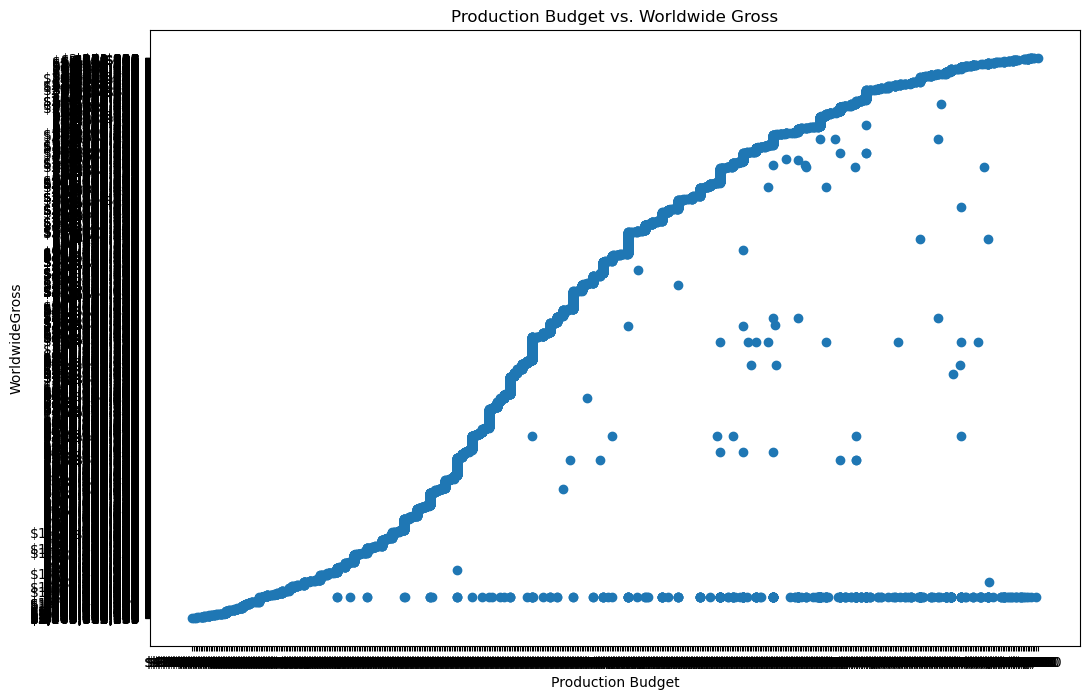

In [ ]:
plt.figure(figsize = (12,8))
plt.scatter(movie_budgets_df['production_budget'],movie_budgets_df['worldwide_gross'])
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Production Budget vs. Worldwide Gross')
plt.show()

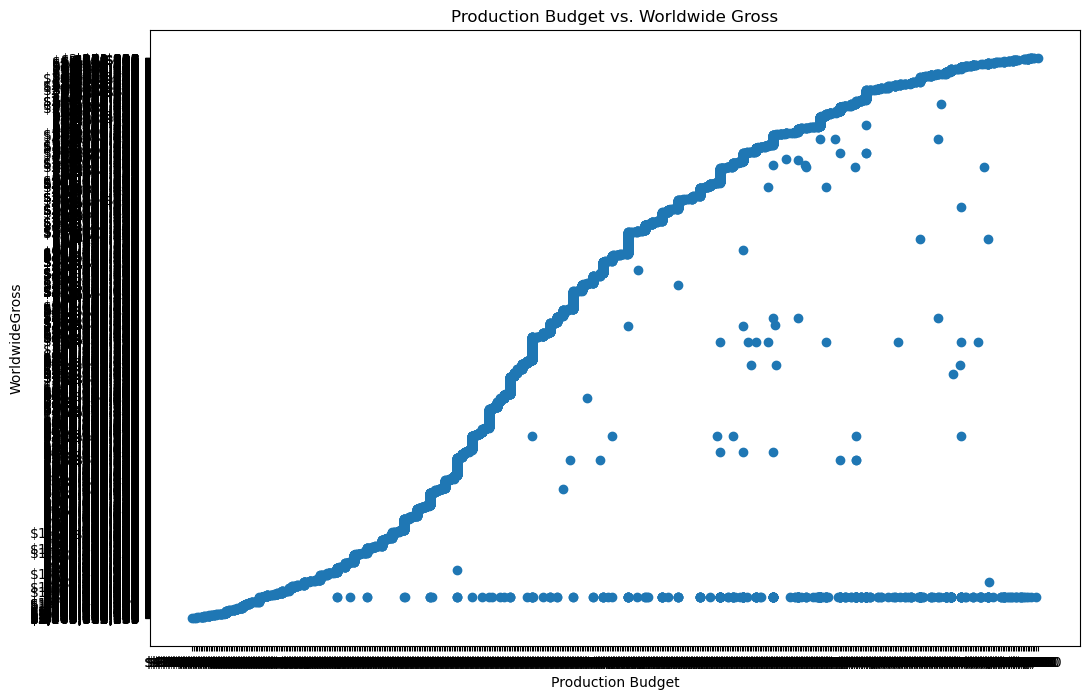

In [ ]:
plt.figure(figsize = (12,8))
plt.scatter(movie_budgets_df['production_budget'],movie_budgets_df['worldwide_gross'])
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Production Budget vs. Worldwide Gross')
plt.show()

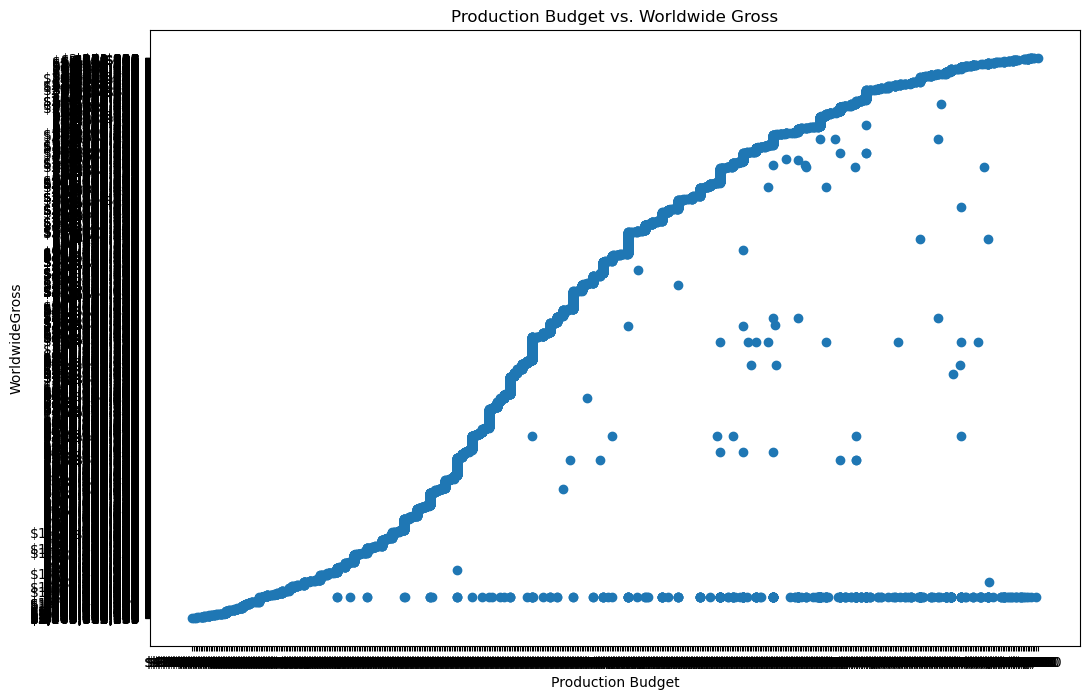

In [ ]:
plt.figure(figsize = (12,8))
plt.scatter(movie_budgets_df['production_budget'],movie_budgets_df['worldwide_gross'])
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Production Budget vs. Worldwide Gross')
plt.show()

#### Visualizing datasets

In [ ]:
# Cleaning currency strings
def clean_currency(x):
    if isinstance(x,str):
        return float(x.replace('$',").replace(',',"))
    return x
